In [1]:
# upload QQQ price file to Colab - QQQ-LSTM.CSV
!rm qqq.csv
!rm qqq-lstm.csv

from google.colab import files
uploaded = files.upload()

rm: cannot remove 'qqq.csv': No such file or directory
rm: cannot remove 'qqq-lstm.csv': No such file or directory


Saving qqq-lstm.csv to qqq-lstm.csv


In [12]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

### Load prices

* split dataset; last 14 days for testing/eval prediction
* load prices into dataframe
* log() the price series
* plot original and logged series

       adjusted
0    104.816719
1    104.634834
2    103.629753
3    100.384743
4     99.561531
..          ...
512  160.200790
513  161.929535
514  161.958893
515  162.466751
516  164.205338

[517 rows x 1 columns]


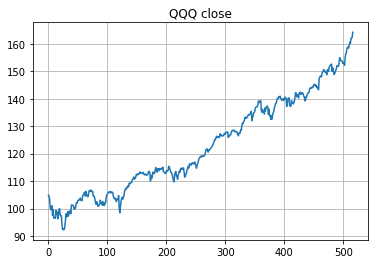

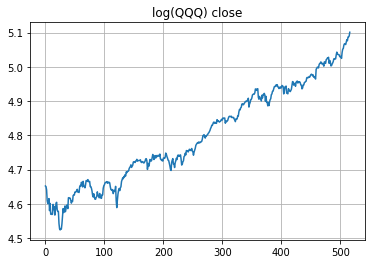

In [13]:
dataframe = pd.read_csv('./qqq-lstm.csv', usecols=[1], engine='python')
print(dataframe)

dataset = dataframe.values
dataset = dataset.astype('float32')

fig, ax = plt.subplots()
ax.plot(dataset)
ax.set(title='QQQ close')
ax.grid()
plt.show()

dataset1 = numpy.log(dataset)
fig, ax = plt.subplots()
ax.plot(dataset1)
ax.set(title='log(QQQ) close')
ax.grid()
plt.show()



### Preprocess data for LSTM

* MinMax scale the data 
* split data into training and test (last 20 days for testing)
* reshape into LSTM matrix 
* use 1 day lookback

In [14]:
# normalize the dataset
train = dataset1[:-14]
test = dataset1[-16:]

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(dataset1)
train = scaler.transform(train)
test = scaler.transform(test)

# split into train and test sets on logged dataset
#test_size = 20
#train_size = len(dataset1) - test_size
#train, test = dataset1[0:train_size,:], dataset1[train_size:len(dataset),:]
#print(len(train), len(test))

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

# fix random seed for reproducibility
numpy.random.seed(7)

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


### Create and fit LSTM network

* 4 LSTM units
* make predictions
* invert predictions for scaling (recall we MimMax scaled)

In [15]:
# build network and fit model
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1)

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

print (testPredict)

# invert predictions for scaling
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# invert predictions for log transform
trainPredict1 = numpy.exp(trainPredict)
trainY1 = numpy.exp(numpy.transpose(trainY))
testPredict1 = numpy.exp(testPredict)
testY1 = numpy.exp(numpy.transpose(testY))

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

trainScore = math.sqrt(mean_squared_error(trainY1[:,0], trainPredict1[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY1[:,0], testPredict1[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Epoch 1/100
501/501 [==============================] - 3s 2ms/step - loss: 0.1701
Epoch 2/100
501/501 [==============================] - 1s 2ms/step - loss: 0.0258
Epoch 3/100
501/501 [==============================] - 1s 2ms/step - loss: 0.0111
Epoch 4/100
501/501 [==============================] - 1s 2ms/step - loss: 0.0021
Epoch 5/100
501/501 [==============================] - 1s 2ms/step - loss: 2.5035e-04
Epoch 6/100
501/501 [==============================] - 1s 2ms/step - loss: 2.3528e-04
Epoch 7/100
501/501 [==============================] - 1s 2ms/step - loss: 2.4705e-04
Epoch 8/100
501/501 [==============================] - 1s 2ms/step - loss: 2.8525e-04
Epoch 9/100
501/501 [==============================] - 1s 2ms/step - loss: 2.3282e-04
Epoch 10/100
501/501 [==============================] - 1s 2ms/step - loss: 2.6854e-04
Epoch 11/100
501/501 [==============================] - 1s 2ms/step - loss: 2.0266e-04
Epoch 12/100
501/501 [==============================] - 1s 2ms/step 

In [16]:
# plot baseline and predictions

# shift train predictions for plotting
#trainPredictPlot = numpy.empty_like(dataset1)
#trainPredictPlot[:, :] = numpy.nan
#trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
#testPredictPlot = numpy.empty_like(dataset1)
#testPredictPlot[:, :] = numpy.nan
#testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset1)-1, :] = testPredict

#fig, ax = plt.subplots()
#ax.plot(scaler.inverse_transform(dataset1))
#ax.plot(trainPredictPlot)
#ax.plot(testPredictPlot)
#ax.set(title='log(QQQ) predictions (training and test)')
#ax.grid()
#plt.show()

### these predictions are 1 day based on prior day value


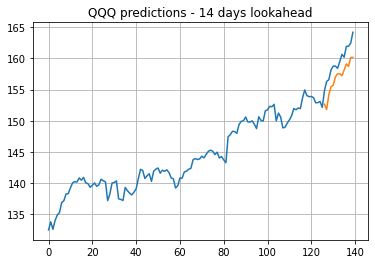

In [17]:
# just use last 6 months of series - 140 days as for GARCH model
n = 140
seriesPlot = dataset[-n:]
predictPlot = numpy.empty((n,1))
predictPlot[:-14] = numpy.nan
predictPlot[-14:] = testPredict1

fig, ax = plt.subplots()
ax.plot(seriesPlot)
ax.plot(predictPlot)
ax.set(title='QQQ predictions - 14 days lookahead')
ax.grid()
plt.show()

In [18]:
math.sqrt(mean_squared_error(dataset[-14:], predictPlot[-14:]))
print(dataset[-14:], predictPlot[-14:])

[[154.79958]
 [156.30368]
 [156.5772 ]
 [158.14967]
 [158.76503]
 [158.77478]
 [158.40361]
 [159.48778]
 [160.65985]
 [160.20079]
 [161.92953]
 [161.9589 ]
 [162.46675]
 [164.20534]] [[152.64178467]
 [151.80348206]
 [154.14581299]
 [155.44372559]
 [155.67782593]
 [157.01309204]
 [157.5305481 ]
 [157.53881836]
 [157.2270813 ]
 [158.13473511]
 [159.10604858]
 [158.72679138]
 [160.14663696]
 [160.17062378]]


#### predict 14 days ahead from series


In [19]:
prev = train[-1]
preds = numpy.zeros(14)
for i in range(14):
  prev = model.predict(numpy.reshape(prev, (1,1,1)))
  preds[i] = numpy.exp(scaler.inverse_transform(prev))

preds



array([151.80348206, 151.5103302 , 151.24871826, 151.01501465,
       150.80548096, 150.61761475, 150.44865417, 150.29656982,
       150.1594696 , 150.03578186, 149.92401123, 149.82302856,
       149.73153687, 149.64872742])

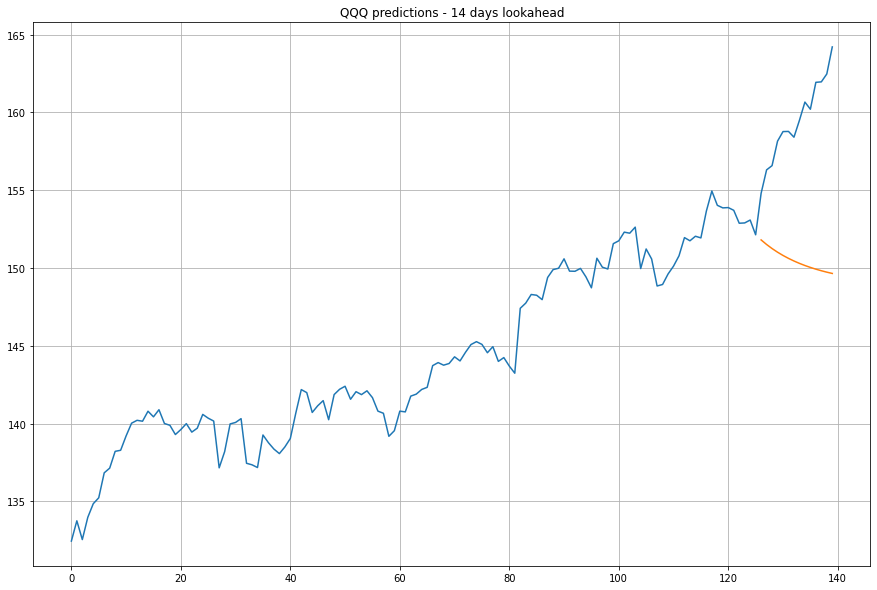

rmse: 9.51682713813392


In [27]:
predictPlot[-14:] = numpy.reshape(preds,(14,1))

fig, ax = plt.subplots(figsize=(15,10))
ax.plot(seriesPlot)
ax.plot(predictPlot)
ax.set(title='QQQ predictions - 14 days lookahead')
ax.grid()
plt.show()

print('rmse:', math.sqrt(mean_squared_error(seriesPlot[-14:], predictPlot[-14:])))
